## Load libraries

In [1]:
accesibilidad_urbana = "../../../"

In [2]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join(accesibilidad_urbana))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

In [75]:
projected_crs = "EPSG:32719"
save = True

## Load data

Load calidad ep data (streets)

In [19]:
calidad_ep_dir = accesibilidad_urbana + "data/external/santiago/calidad_ep/"
calidad_ep = gpd.read_file(calidad_ep_dir + "00_redvial2019_buffer_3750m_c_utilidad_2/original_file/redvial2019_buffer_3750m_c_utilidad_2.shp")
calidad_ep = calidad_ep.set_crs(projected_crs)
calidad_ep = calidad_ep.to_crs("EPSG:4326")

# Show
print(calidad_ep.crs)
print(calidad_ep.shape)
calidad_ep.head(2)

EPSG:4326
(31534, 36)


,IDcllbf,shp_lng,st_lng_,Nom_Rut,Rol_Mop,Clas_Rt,Tip_Crp,Catego,Cod_Rgn,id,...,nr_trtr,ndvi_mn,ndvi_md,es_cll_,utilidd,rank_tl,pje_ep,UV,buffer800,geometry
0,1.0,0.000000,1813.857525,Túnel Kennedy,None,5,None,Urbano,13,1.0,...,0.0,0.121441,0.136500,1.0,0.184971,6596.0,0.209171,0,0,"LINESTRING (-70.60280 -33.40858, -70.60255 -33..."
1,2.0,500.073885,33.924649,Av.Dag Hammarskjöld,None,3,None,Urbano,13,1.0,...,0.0,0.162665,0.171817,1.0,0.245950,8637.0,0.273895,0,0,"LINESTRING (-70.60036 -33.40805, -70.60032 -33..."


Load hexs

In [30]:
res = 9

# aoi
aoi_schema = 'projects_research'
aoi_table = 'santiago_aoi'
city = 'alamedabuffer_4500m'
query = f"SELECT * FROM {aoi_schema}.{aoi_table} WHERE \"city\" LIKE \'{city}\'"
aoi = aup.gdf_from_query(query, geometry_col='geometry')

# Create hexs for aoi in buffer around aoi
aoi = aoi.to_crs(projected_crs)
aoi_buffer = aoi.buffer(500)
aoi = aoi.to_crs("EPSG:4326")

aoi_buffer_gdf = gpd.GeoDataFrame(geometry=aoi_buffer,crs=projected_crs)
aoi_buffer_gdf = aoi_buffer_gdf.to_crs("EPSG:4326")

hex_in_buffer = aup.create_hexgrid(aoi_buffer_gdf, hex_res=res)
hex_in_buffer.rename(columns={f'hex_id_{res}':'hex_id'}, inplace=True)
hex_in_buffer['res'] = res

# Select hexs that touch aoi
hex_in_aoi = gpd.sjoin(hex_in_buffer, aoi)
hex_in_aoi.drop(columns=['index_right'],inplace=True)

# Show
print(hex_in_aoi.crs)
print(hex_in_aoi.shape)
hex_in_aoi.head(2)

EPSG:4326
(1524, 4)


,hex_id,geometry,res,city
0,89b2c556a93ffff,"POLYGON ((-70.62964 -33.41721, -70.63082 -33.4...",9,alamedabuffer_4500m
1,89b2c5558c7ffff,"POLYGON ((-70.70643 -33.47390, -70.70761 -33.4...",9,alamedabuffer_4500m


<Axes: >

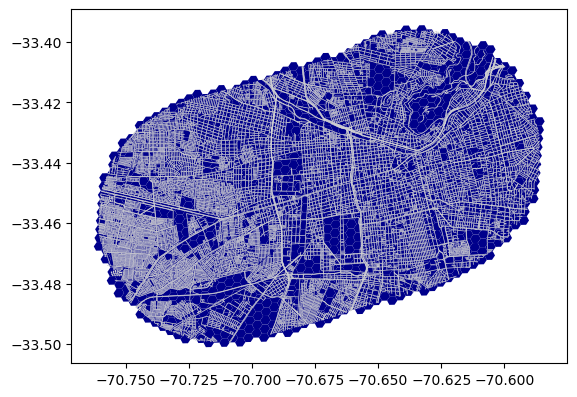

In [31]:
fig,ax = plt.subplots()

calidad_ep.plot(ax=ax,zorder=1,linewidth=0.5,edgecolor='lightgray')
hex_in_aoi.plot(ax=ax,zorder=0,color='darkblue')

## Intersect calidad ep data using hexs

In [59]:
intersected_calidad_ep_hex = gpd.overlay(calidad_ep, hex_in_aoi,how='intersection')
# Show
print(intersected_calidad_ep_hex.crs)
print(intersected_calidad_ep_hex.shape)
intersected_calidad_ep_hex.head(2)

EPSG:4326
(41650, 39)


,IDcllbf,shp_lng,st_lng_,Nom_Rut,Rol_Mop,Clas_Rt,Tip_Crp,Catego,Cod_Rgn,id,...,es_cll_,utilidd,rank_tl,pje_ep,UV,buffer800,hex_id,res,city,geometry
0,1.0,0.000000,1813.857525,Túnel Kennedy,None,5,None,Urbano,13,1.0,...,1.0,0.184971,6596.0,0.209171,0,0,89b2c556d5bffff,9,alamedabuffer_4500m,"LINESTRING (-70.60176 -33.40841, -70.60152 -33..."
1,2.0,500.073885,33.924649,Av.Dag Hammarskjöld,None,3,None,Urbano,13,1.0,...,1.0,0.245950,8637.0,0.273895,0,0,89b2c556d5bffff,9,alamedabuffer_4500m,"LINESTRING (-70.60036 -33.40805, -70.60032 -33..."


<Axes: >

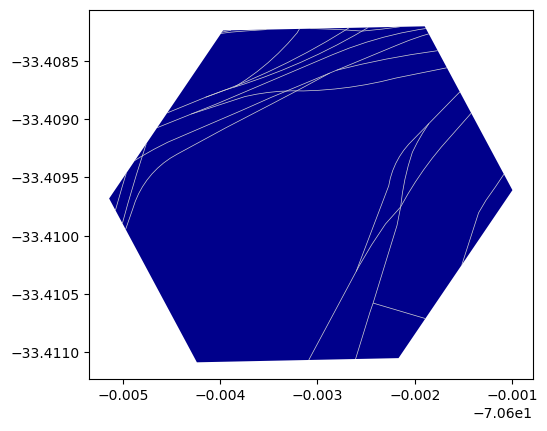

In [60]:
# Intersected result visualization
fig,ax = plt.subplots()
intersected_calidad_ep_hex.loc[intersected_calidad_ep_hex.hex_id=="89b2c556897ffff"].plot(ax=ax,zorder=1,linewidth=0.5,edgecolor='lightgray')
hex_in_aoi.loc[hex_in_aoi.hex_id=="89b2c556897ffff"].plot(ax=ax,zorder=0,color='darkblue')

## Calculate average pje_ep by hex

In [64]:
hex_gdf = hex_in_aoi.copy()

# Calculate intersected lines length
intersected_calidad_ep_hex = intersected_calidad_ep_hex.to_crs(projected_crs)
intersected_calidad_ep_hex['length'] = intersected_calidad_ep_hex.length
intersected_calidad_ep_hex = intersected_calidad_ep_hex.to_crs("EPSG:4326")

# Calculate weighted average
for hex_id in list(intersected_calidad_ep_hex.hex_id.unique()):

    # Find value for hex's streets
    streets_in_hex = intersected_calidad_ep_hex.loc[intersected_calidad_ep_hex.hex_id == hex_id].copy()
    weighted_avg = aup.weighted_average(streets_in_hex,'length','pje_ep')

    # Register value
    idx = hex_gdf.hex_id == hex_id
    hex_gdf.loc[idx,'pje_ep'] = weighted_avg

# Show
print(hex_gdf.crs)
print(hex_gdf.shape)
hex_gdf.head(2)

EPSG:4326
(1524, 5)


,hex_id,geometry,res,city,pje_ep
0,89b2c556a93ffff,"POLYGON ((-70.62964 -33.41721, -70.63082 -33.4...",9,alamedabuffer_4500m,0.994048
1,89b2c5558c7ffff,"POLYGON ((-70.70643 -33.47390, -70.70761 -33.4...",9,alamedabuffer_4500m,0.490898


## Save

In [77]:
if save:
    save_dir = accesibilidad_urbana + "data/external/santiago/calidad_ep/"
    hex_gdf.to_file(save_dir + f"calidad_ep_hex9.gpkg", driver='GPKG')